In [2]:
import time
import os
import math
import numpy as np
import cv2
import pandas as pd
import pyautogui as pa
from scipy.stats import binom_test
from matplotlib.markers import TICKDOWN
from matplotlib import rcParams
import datetime
from scipy.stats import norm, kstest, sem, ttest_ind
from numpy.polynomial import polynomial
import imageio

from lib.auto_GUI.auto_GUI_base import AutoGUIBase
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ
from lib.analysis.laminar_dist import *
from lib.file.ROI_reader import ROIFileReader
from lib.analysis.cell_roi import OverlapCounterROI
from lib.analysis.baseline_correction import BaselineCorrection

c:\Users\jjudge3\Anaconda3\envs\TSM-to-ZDA\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
C:\Users\jjudge3\AppData\Roaming\Python\Python39\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/controlled_baseline/"
master_csv = data_dir + 'scnn1a-ppr.csv'
###################################
# SUMATION DECOMPOSITION
# UPDATE: Every other trace is a single-pulse control, for baseline subtraction and summation decomposition
# UPDATE: Data is right-aligned in the trace, the second pulse is always at point ~360
# Process paired-pulse ratio data
#    - IPIs are shuffled, open <slice>_<loc>shuffle.txt for IPI order
#    - extract Amplitude, half_width, latency for pulse 1 and pulse 2 for each ROI
#    - ROIs are in order (in file "<slice>_barrel_rois.dat" for each date subdir):
#          -  medial -> lateral if available
#          - otherwise, in some order that preserves neighbors (1,2 are neighbors and 2,3 are neighbors)
#    - which barrel is home barrel (stimulated) is recorded in master csv scnn1a-ppr.csv for each loc
###################################
enable_photoZ_interact = False
initialize_photoZ = False

# Amp cutoff is slice/loc specific, see scnn1a-ppr.csv

In [4]:
# set up PhotoZ (open it manually)
aPhz = AutoPhotoZ(data_dir=data_dir)
if initialize_photoZ and enable_photoZ_interact:
    aPhz.prepare_photoZ()
    # normalization needs to be off since we are saving arrays
    # aPhz.click_normalize_2_array_max()

In [5]:
# load master csv file for metadata
master_df = pd.read_csv(master_csv)
master_df = pd.DataFrame(master_df)
master_df

,Date,Slice_Loc,Medial Dir,Stim Layer,Caudal/Rostral,Home Barrel,AmpCutoff
0,5/6/2024,1_1,NaN,L4,Rostral,1,1.1
1,5/6/2024,2_1,NaN,L4,Rostral,2,1.1
2,5/9/2024,2_1,NaN,L4,Rostral,2,0.9
3,5/9/2024,2_2,NaN,L4,Rostral,1,0.6
4,5/9/2024,3_1,NaN,L4,Caudal,1,1.1
5,5/14/2024,1_2,NaN,L4,Caudal,1,1.1
6,5/14/2024,2_1,NaN,L4,Rostral,2,1.1
7,5/15/2024,1_1,NaN,L4,Rostral,2,1.1
8,5/15/2024,2_1,NaN,L4,Rostral,2,1.1
9,5/15/2024,3_1,NaN,L4,Rostral,1,1.1


In [6]:
def get_shuffle_filename(slic, loc):
    return str(slic) + "_" + str(loc) + "shuffle.txt"

def get_barrel_roi_filename(slic):
    return str(slic) + "_barrel_rois.dat"

# locate all files
data_map = {}
for subdir, dirs, files in os.walk(data_dir):
    if 'hidden' in subdir:
        continue
    if not ('dic' in dirs and 'selected_zda' in dirs):
        continue
    print("\n", subdir)
    dic_dir = subdir + "/dic/"
    selected_zda_dir = subdir + "/selected_zda/"
    data_map[subdir] = {}
    for zda_file in os.listdir(selected_zda_dir):
        if zda_file.endswith('.zda'):
            slr_id = zda_file.split('.')[0]
            slic_id, loc_id, rec_id = [int(x) for x in slr_id.split("_")]
            print(slic_id, loc_id, rec_id)
            if slic_id not in data_map[subdir]:
                # find ROI file and index it
                data_map[subdir][slic_id] = {'roi_file': selected_zda_dir + "/" + get_barrel_roi_filename(slic_id)}
            if loc_id not in data_map[subdir][slic_id]:
                # find shuffle file and index it
                data_map[subdir][slic_id][loc_id] = {'zda_files': [],
                                                     'shuffle_file': subdir + "/" +  get_shuffle_filename(slic_id, loc_id)}
            data_map[subdir][slic_id][loc_id]['zda_files'].append(selected_zda_dir + "/" + zda_file)  # appends in ascending order

In [7]:
# go through the IPIs in their shuffled order (ascending recordings) 
# and extract the entire trace for each ROI
# Every second recording is a single-pulse control
initial_sweep = True
if enable_photoZ_interact:
    pa.alert("Starting trace extraction, set trace window to 0,2000 in Save/Load tab!")
for subdir in data_map:
    aPhz = AutoPhotoZ(data_dir=subdir)
    print(subdir)
    for slic_id in data_map[subdir]:

        # open roi_file for whole slice
        if enable_photoZ_interact:
            roi_file = data_map[subdir][slic_id]['roi_file']
            aPhz.select_roi_tab()
            aPhz.open_roi_file(roi_file)
            if initial_sweep:
                aPhz.change_baseline_correction(polynomial=False)
                initial_sweep = False

        for loc_id in data_map[subdir][slic_id]:
            if type(loc_id) == str:
                continue
            slic_loc_id = str(slic_id) + "_" + str(loc_id)

            ipi_file = data_map[subdir][slic_id][loc_id]['shuffle_file']
            with open(ipi_file, 'r') as f:
                lines = f.readlines() 
            ipi_order = [x for x in lines]
            control_orders = []
            for k in range(len(ipi_order)):
                ipi = ipi_order[k].split("\t")

                # if there is a third number, it is 0 or 1 for control order. Else control order is 1.
                control_order = 1
                if len(ipi) == 3:
                    control_order = int(ipi[2])
                control_orders.append(control_order)

                ipi = int(ipi[1]) - int(ipi[0])
                
                ipi_order[k] = ipi

            if len(data_map[subdir][slic_id][loc_id]['zda_files']) % 2 != 0:
                raise Exception("Odd number of recordings for", subdir, slic_id, loc_id, "may be missing " +
                                "a single-pulse control!")
            # open zda files in order
            i_ipi = -1
            for i_zda_file in range(0, len(data_map[subdir][slic_id][loc_id]['zda_files']), 2):
                zda_file = data_map[subdir][slic_id][loc_id]['zda_files'][i_zda_file]
                i_ipi += 1
                try:
                    ipi = ipi_order[i_ipi]
                    control_order = control_orders[i_ipi]
                except Exception as e:
                    print(e)
                    print("Not enough IPIs for how many recordings we have! Last IPI:", ipi, "Check", subdir)
                

                next_zda_file = data_map[subdir][slic_id][loc_id]['zda_files'][i_zda_file + 1]
                next_trace_filename = subdir + "/" + "traces_" + slic_loc_id + "_ipi" + str(ipi) + "_control.dat"
                # if control_order is 0, then we have to swap zda_file and next_zda_file since the control is first and the recording is second
                if control_order == 0:
                    zda_file, next_zda_file = next_zda_file, zda_file
                print(slic_id, loc_id, "IPI:", ipi, "ms for recording", zda_file.split("/")[-1])

                # save entire traces
                trace_filename = subdir + "/" + "traces_" + slic_loc_id + "_ipi" + str(ipi) + ".dat"
                is_loaded_zda_file = False
                if os.path.exists(trace_filename):
                    print("\tAlready saved trace", trace_filename)
                    is_loaded_zda_file = False
                elif enable_photoZ_interact:
                    aPhz.open_zda_file(zda_file)
                    time.sleep(13)
                    print("\tSaving traces...")
                    aPhz.save_current_traces(trace_filename, go_to_tab=True)
                    print("\tSaved trace", trace_filename)
                    is_loaded_zda_file = True

                # save baselined traces
                trace_baselined_filename = subdir + "/" + "traces_baselined_" + slic_loc_id + "_ipi" + str(ipi) + ".dat"
                if os.path.exists(trace_baselined_filename):
                    print("\tAlready saved trace", trace_baselined_filename)
                elif enable_photoZ_interact:
                    if not is_loaded_zda_file:
                        aPhz.open_zda_file(zda_file)
                        time.sleep(13)
                        is_loaded_zda_file = True
                    # now apply baseline correction around both pulses and save the whole trace
                    aPhz.change_baseline_correction(polynomial=True)
                    # set polynomial skip window to eclipse BOTH pulses
                    end_skip = 550
                    first_pulse_start = 356 - (ipi * 2)
                    skip_width = end_skip - first_pulse_start
                    aPhz.set_polynomial_skip_window(first_pulse_start,
                                                    skip_width=skip_width)
                    print("\tSaving traces...")
                    aPhz.save_current_traces(trace_baselined_filename, go_to_tab=True)
                    print("\tSaved trace", trace_baselined_filename)
                    aPhz.change_baseline_correction(polynomial=False)

                # go to next trace and save control trace
                if os.path.exists(next_trace_filename):
                    print("\tAlready saved trace", next_trace_filename)
                elif enable_photoZ_interact:
                    aPhz.open_zda_file(next_zda_file)
                    time.sleep(13)
                    print("\tSaving traces...")
                    aPhz.save_current_traces(next_trace_filename, go_to_tab=True)
                    print("\tSaved trace", next_trace_filename)

                data_map[subdir][slic_id][loc_id][ipi] = {'trace': trace_filename,
                                                          'trace_baselined': trace_baselined_filename,
                                                          'control_trace': next_trace_filename}
            if i_ipi < len(ipi_order) - 1:
                print("Not enough recordings for how many IPIs we have! Last IPI:", ipi, "Check", subdir)


In [8]:
control_match_dist_cutoff = 0.2  # if STDEV of subtraction is greater than this, skip
plot_traces = True

task = "export"  # review or export

# review: see all traces, annotated
if task == 'review':
    remove_filters = True
    export_movie = False
    annotate_traces = True

# export: save filtered traces to gif
if task == 'export':
    remove_filters = False
    export_movie = True
    annotate_traces = False

'''Now load traces and perform summation decomposition by 
subtracting the control trace from the paired-pulse trace. '''
def read_dat_trace_file(filename):
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=0)  # change me to traces?
    data_arr = data_arr.apply(pd.to_numeric, errors='coerce')
    return data_arr

df_lists = {'IPI': [], 'ROI': [], 'Medial Dir': [], 'Stim Layer': [], 'Caudal Rostral': [], 'Home Barrel': [],
            'Date': [], 'Slice_Loc': [], 'PPR': [],
            'First Max Composed': [], 'Second Max Composed': [],
            'First Max Controlled': [], 'Second Max Controlled': [], 'PPR Composed': []}


dfs = []
for subdir in data_map:
    
    # extract date from subdir so we can look up metadata from master_df
    date = subdir.split("/")[-1].split('-')
    date = [int(x) for x in date]
    date[-1] += 2000
    date = "/".join([str(x) for x in date])
    metadata_date = master_df[master_df['Date'] == date]
    
    for slic_id in data_map[subdir]:
        for loc_id in data_map[subdir][slic_id]:
            if type(loc_id) == str:
                continue
            slic_loc_id = str(slic_id) + "_" + str(loc_id)
            amp_cutoff = float(master_df[(master_df['Date'] == date) & (master_df['Slice_Loc'] == slic_loc_id)]['AmpCutoff'].item())
            print(date, slic_loc_id)
            metadata = metadata_date[metadata_date['Slice_Loc'] == slic_loc_id]
            medial_dir = metadata['Medial Dir'].item()
            stim_layer = metadata['Stim Layer'].item()
            caudal_rostral = metadata['Caudal/Rostral'].item()
            home_barrel = int(metadata['Home Barrel'].item())

            movies = {}

            for ipi in data_map[subdir][slic_id][loc_id]:
                if type(ipi) == str:
                    continue
                print("\tIPI:", ipi)

                # load traces and control traces for this ipi
                trace_filename = data_map[subdir][slic_id][loc_id][ipi]['trace']
                control_trace_filename = data_map[subdir][slic_id][loc_id][ipi]['control_trace']
                trace_baselined_filename = data_map[subdir][slic_id][loc_id][ipi]['trace_baselined']
                trace = read_dat_trace_file(trace_filename)
                control_trace = read_dat_trace_file(control_trace_filename)
                baselined_trace = read_dat_trace_file(trace_baselined_filename)

                # show both traces and their subtraction
                trace_sub = trace - control_trace
                trace_sub = trace_sub.drop(columns=['Pt'])
                trace_sub = trace_sub.dropna()

                # calculate dist from zero of subtracted trace before second stim
                trace_sub_dist = trace_sub[(trace_sub.index < 356) | (trace_sub.index > 550)].abs().mean()

                # calculate maxAmp of subtracted trace in measure window (356 - 450)
                trace_sub_max = trace_sub[(trace_sub.index > 356) & (trace_sub.index < 450)].max()

                # perform baseline subtraction on control trace
                first_stim_start = 356 - (ipi * 2)
                exclusion_window = (first_stim_start, first_stim_start + 290)
                bc = BaselineCorrection(control_trace, exclusion_windows=[exclusion_window])
                control_trace_max = {}
                control_trace_corrected = {}
                for roi in control_trace.columns:
                    if roi == 'Pt':
                        continue
                    control_trace_corrected[roi] = bc.fit_baseline(roi, date+ " " + slic_loc_id + " IPI " + str(ipi) + "ms")
                    # measure MaxAmp of control trace in first stim site measure window

                    control_trace_max[roi] = control_trace[(control_trace.index > first_stim_start) 
                                                        & (control_trace.index < first_stim_start + 104)]['Corrected_'+roi].max()
                
                # extract first and second maxAmp of baselined_trace
                first_max_baselined = baselined_trace[(baselined_trace.index > first_stim_start) & 
                                                      (baselined_trace.index < 345)].max()
                second_max_baselined = baselined_trace[(baselined_trace.index > 356) & (baselined_trace.index < 550)].max()

                for roi in control_trace.columns:
                    if not ('ROI' in roi and len(roi) == 4):
                        continue

                    n_roi = int(roi[3])

                    # filters
                    if not remove_filters:
                        if trace_sub_dist[roi] > control_match_dist_cutoff:  # skip if magnitude of subtraction is too high
                            continue
                        if trace_sub_max[roi] < amp_cutoff and control_trace_max[roi] < amp_cutoff:  # skip if maxAmp of subtraction is too low
                            continue
                    if plot_traces:
                        plt.rcParams["figure.figsize"] = 10, 3
                        plt.rcParams.update({'font.size': 12})
                        fig, axes = plt.subplots(ncols=2, gridspec_kw={"width_ratios":[4, 1]})
                        axes[0].plot(trace[roi], c='tab:orange', label= roi + ' raw')
                        axes[0].plot(control_trace[roi], 'k--', label= roi + ' control', alpha=0.5)
                        axes[0].plot(trace_sub[roi], c='tab:blue', label= roi + ' subtraction = raw - control')
                        axes[0].plot(control_trace_corrected[roi], c='tab:blue', label= roi + ' control w/ polyfit', alpha=0.5)

                        ceiling_1 = 1.2 * trace[roi].max()
                        axes[0].plot(baselined_trace[roi] + ceiling_1, c='tab:green', label= roi + ' raw w/ polyfit', alpha=0.5)
                        axes[0].annotate("Mean dist:\n" + str(trace_sub_dist[roi])[:5], 
                                        xy=(100, 1), fontsize=8, color='tab:blue')
                        if annotate_traces:
                            # annotate maxAmp of subtracted trace
                            axes[0].annotate("2nd maxAmp: " + str(trace_sub_max[roi])[:5], xy=(450, 3), fontsize=8, color='tab:blue')
                            # annotate maxAmp of control trace
                            axes[0].annotate("1st maxAmp: " + str(control_trace_max[roi])[:5], xy=(200, 5), fontsize=8, color='tab:blue')

                            # annotate maxAmp of baselined trace
                            axes[0].annotate("2nd maxAmp: " + str(second_max_baselined[roi])[:5], xy=(450, 3+ceiling_1), 
                                            fontsize=8, color='tab:green')
                            # annotate maxAmp of baselined trace
                            axes[0].annotate("1st maxAmp: " + str(first_max_baselined[roi])[:5], xy=(200, 5+ ceiling_1),
                                            fontsize=8, color='tab:green')

                        h, l = axes[0].get_legend_handles_labels()
                        axes[1].legend(h, l, borderaxespad=0)
                        axes[1].axis('off')
                        axes[0].set_yticks([])
                        plt.title(date + " " + slic_loc_id + " IPI " + str(ipi) + "ms")
                        if export_movie:
                            png_filename = subdir + "/Plot-traces" + slic_loc_id + "_IPI" + str(ipi) + "_" + roi + ".png"
                        plt.savefig(png_filename, dpi=300, bbox_inches='tight')
                        plt.show()
                        if roi not in movies:
                            movies[roi] = {}
                        movies[roi][ipi] = png_filename


                    # traces not filtered out: calculate PPR and save metadata to snr_dfs
                    ppr = 0
                    if control_trace_max[roi] != 0:
                        ppr = trace_sub_max[roi] / control_trace_max[roi]

                    # baselined maxamps to composed PPR
                    ppr_composed = 0
                    if first_max_baselined[roi] != 0:
                        ppr_composed = second_max_baselined[roi] / first_max_baselined[roi]

                    df_lists['IPI'].append(ipi)
                    df_lists['ROI'].append(n_roi)
                    df_lists['Medial Dir'].append(medial_dir)
                    df_lists['Stim Layer'].append(stim_layer)
                    df_lists['Caudal Rostral'].append(caudal_rostral)
                    df_lists['Home Barrel'].append(home_barrel)
                    df_lists['Date'].append(date)
                    df_lists['Slice_Loc'].append(slic_loc_id)
                    df_lists['PPR'].append(ppr)
                    df_lists['First Max Composed'].append(first_max_baselined[roi])
                    df_lists['Second Max Composed'].append(second_max_baselined[roi])
                    df_lists['First Max Controlled'].append(control_trace_max[roi])
                    df_lists['Second Max Controlled'].append(trace_sub_max[roi])
                    df_lists['PPR Composed'].append(ppr_composed)
            
            # save movies
            if export_movie:
                for roi in movies:
                    roi_movie = movies[roi]
                    ipis_keys = list(roi_movie.keys())
                    ipis_keys.sort()
                    roi_movie = [roi_movie[ipi] for ipi in ipis_keys]
                    roi_movie = [imageio.imread(img) for img in roi_movie]
                    gif_filename = subdir + "/IPIs_" + slic_loc_id + roi + ".gif"
                    imageio.mimsave(gif_filename, roi_movie, fps=5)
                    print("created movie", gif_filename)
            



In [9]:
# create dataframe from df_lists
df = pd.DataFrame.from_dict(df_lists)
numeric_cols = ['IPI', 'ROI', 'PPR', 'Home Barrel']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
dfs.append(df)
csv_filename = 'scnn1a-ppr-output.csv'
df.to_csv(data_dir + csv_filename, index=False)
df

,IPI,ROI,Medial Dir,Stim Layer,Caudal Rostral,Home Barrel,Date,Slice_Loc,PPR,First Max Composed,Second Max Composed,First Max Controlled,Second Max Controlled,PPR Composed


In [10]:
# load from csv if starting from here
df = pd.read_csv(data_dir + 'scnn1a-ppr-output_all.csv')
df = pd.DataFrame(df)
df

,IPI,ROI,Medial Dir,Stim Layer,Caudal Rostral,Home Barrel,Date,Slice_Loc,PPR,First Max Composed,Second Max Composed,First Max Controlled,Second Max Controlled,PPR Composed
0,80,1,NaN,L4,Rostral,1,5/6/2024,1_1,0.808876,5.219270,4.502480,5.852295,4.73378,0.862665
1,80,2,NaN,L4,Rostral,1,5/6/2024,1_1,0.640646,4.048790,3.180800,4.658954,2.98474,0.785617
2,80,3,NaN,L4,Rostral,1,5/6/2024,1_1,0.684318,1.457880,1.243330,2.025594,1.38615,0.852834
3,30,1,NaN,L4,Rostral,1,5/6/2024,1_1,0.782546,5.301080,5.183830,5.391967,4.21946,0.977882
4,90,1,NaN,L4,Rostral,1,5/6/2024,1_1,0.891755,5.574340,5.114960,5.487850,4.89382,0.917590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,80,2,NaN,L4,Rostral,1,5/16/2024,4_1,0.446541,1.061900,0.681513,1.359136,0.60691,0.641786
128,20,1,NaN,L4,Rostral,1,5/16/2024,4_1,0.787392,2.287390,2.518760,2.540576,2.00043,1.101150
129,20,2,NaN,L4,Rostral,1,5/16/2024,4_1,0.530668,0.811767,0.809224,1.268553,0.67318,0.996867
130,130,1,NaN,L4,Rostral,1,5/16/2024,4_1,0.776740,2.701680,2.272900,2.801208,2.17581,0.841291


In [11]:
for date in df['Date'].unique():
    print(df[df['Date'] == date]['Slice_Loc'].unique())

['1_1' '2_1']
['2_1' '2_2' '3_1']
['1_2' '2_1']
['1_1' '2_1']
['1_1' '4_1']


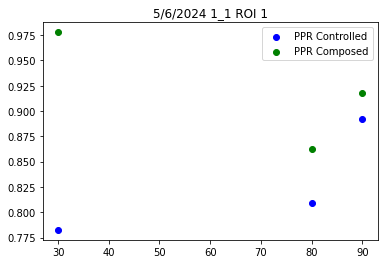

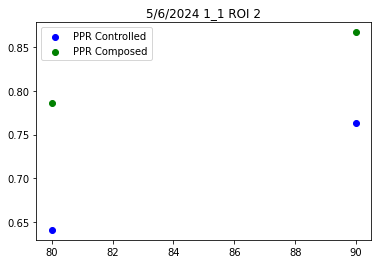

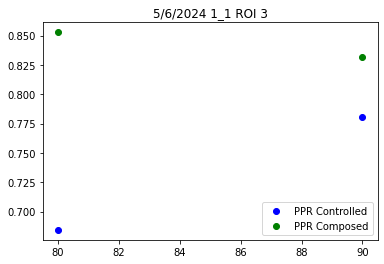

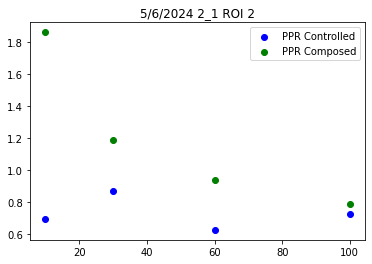

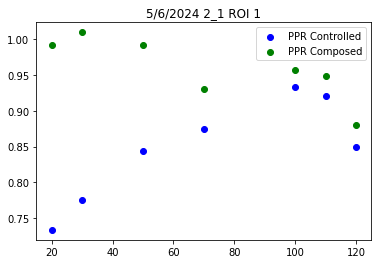

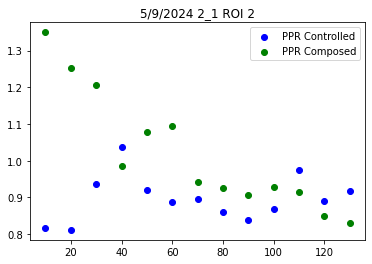

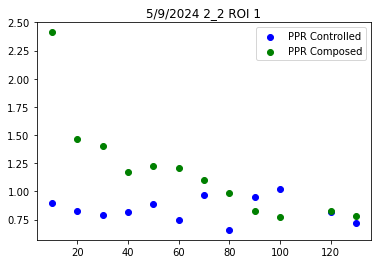

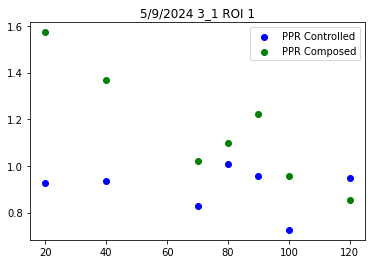

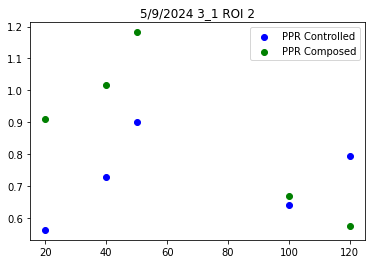

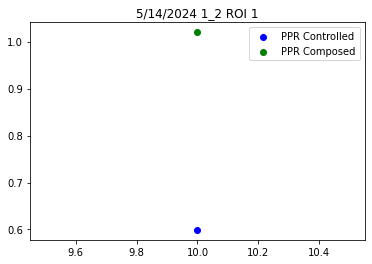

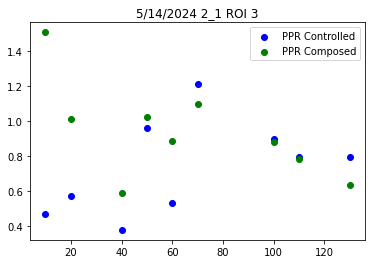

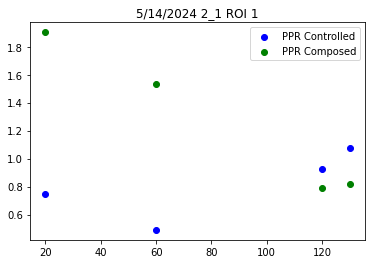

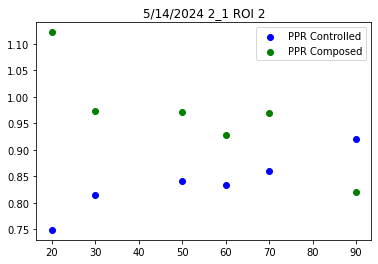

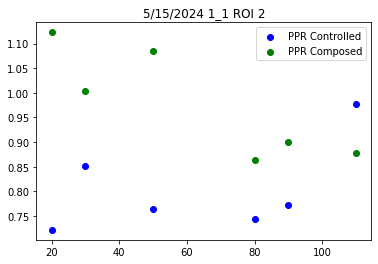

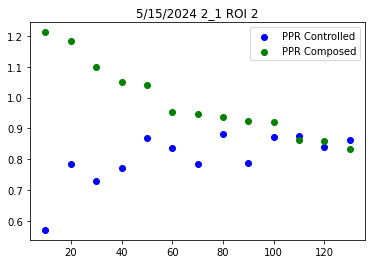

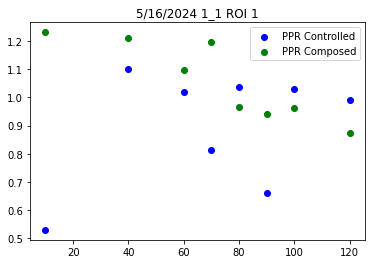

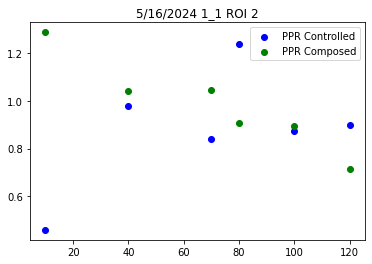

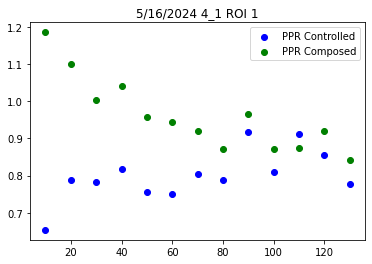

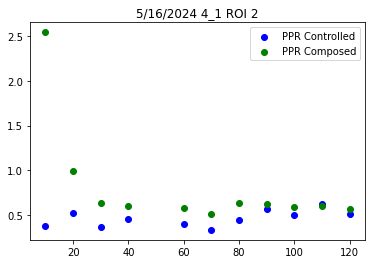

In [12]:
# for each date, slice/loc, and ROI, plot PPR vs IPI
plt.rcParams.update(plt.rcParamsDefault)
for date in df['Date'].unique():
    pfs_date = df[df["Date"] == date]
    for slic_loc in pfs_date['Slice_Loc'].unique():
        pfs_sl = pfs_date[pfs_date["Slice_Loc"] == slic_loc]
        for roi in pfs_sl['ROI'].unique():

            # plot PPR
            pfs_roi = pfs_sl[pfs_sl['ROI'] == roi]
            plt.scatter(pfs_roi['IPI'], pfs_roi['PPR'], label='PPR Controlled', c = 'b')
            plt.title(date + " " + slic_loc + " ROI " + str(roi))

            # plot PPR Composed
            plt.scatter(pfs_roi['IPI'], pfs_roi['PPR Composed'], label='PPR Composed', c='g')
            plt.legend()

            plt.show()
            '''plt.scatter(pfs_roi['IPI'], pfs_roi['PPL'], c='r')
            plt.title(date + " " + slic_loc + " ROI " + str(roi))
            plt.show()
            plt.scatter(pfs_roi['IPI'], pfs_roi['PPHW'], c='g')
            plt.title(date + " " + slic_loc + " ROI " + str(roi))
            plt.show()'''

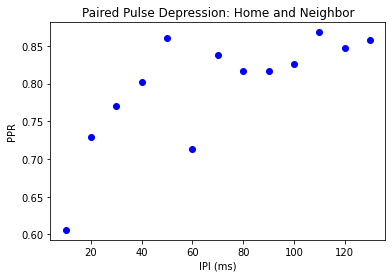

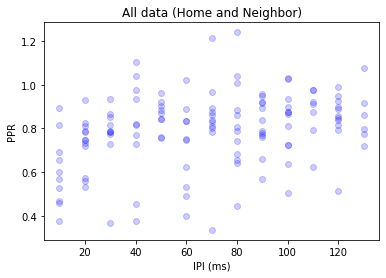

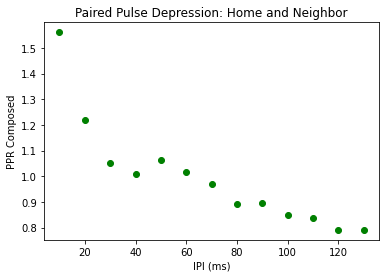

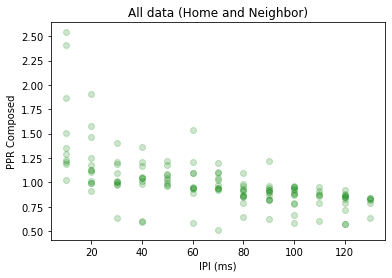

In [13]:
# average grouping by IPI
for pp_type, color in [['PPR', 'b'], ['PPR Composed', 'g']]: #, ['PPL', 'r'], ['PPHW', 'g']]:
    group_by_ipi = df[['IPI', pp_type]].groupby(by=['IPI']).mean()
    group_by_ipi_std = df[['IPI', pp_type]].groupby(by=['IPI']).agg(np.std)
    group_by_ipi.reset_index(inplace=True)
    
    

    # plot average PPR vs IPI
    plt.scatter(group_by_ipi['IPI'], group_by_ipi[pp_type], c=color)
    plt.title("Paired Pulse Depression: Home and Neighbor")
    plt.xlabel("IPI (ms)")
    plt.ylabel(pp_type)
    plt.show()
    plt.scatter(df['IPI'], df[pp_type], alpha=0.2, c=color)
    plt.xlabel("IPI (ms)")
    plt.ylabel(pp_type)
    plt.title("All data (Home and Neighbor)")
    plt.show()

In [24]:
# home barrel or neighboring barrel
plt.rcParams.update({'font.size': 16})

home_barrel_df = df.query('`Home Barrel` == ROI')
neighbor_barrel_df = df.query('`Home Barrel` != ROI')
titles = ['Home Barrel', 'Neighbor Barrel']

for pp_type, color in [['PPR', 'b'], ['PPR Composed', 'g']]: #, ['PPL', 'r'], ['PPHW', 'g']]:
    i = 0
    for barrel_df in [home_barrel_df, neighbor_barrel_df]:
        
        if pp_type in ['PPL', 'PPHW']:
            barrel_df = barrel_df[barrel_df['IPI'] > 20]
        group_by_ipi = barrel_df[['IPI', pp_type]].groupby(by=['IPI']).mean()
        group_by_ipi_std = barrel_df[['IPI', pp_type]].groupby(by=['IPI']).agg(np.std) / np.sqrt(len(barrel_df))
        group_by_ipi.reset_index(inplace=True)

        count_by_ipi = barrel_df[['IPI', pp_type]].groupby(by=['IPI']).count()
        print(count_by_ipi)

        # significance tests against the first IPI
        first_ipi = np.min(group_by_ipi['IPI'])
        pvals = []
        print("i=", i)
        if pp_type == 'PPR' and titles[i] == 'Neighbor Barrel':
            first_ipi = 110
        print(first_ipi)
        
        first_ipi_data = barrel_df[barrel_df['IPI'] == first_ipi][pp_type]
        for ipi in group_by_ipi['IPI']:
            if ipi == first_ipi:
                pvals.append(1)
                continue
            ipi_data = barrel_df[barrel_df['IPI'] == ipi][pp_type]
            
            # one-sided t-test if ipi_data is less than first_ipi_data
            t_stat, p_val = ttest_ind(ipi_data, first_ipi_data, alternative='less', equal_var=False)
            print("p_val for IPI", ipi, ":", p_val)
            pvals.append(p_val)

        def get_sig_level(x):
            if x < 0.001:
                return '***'
            if x < 0.01:
                return '**'
            if x < 0.05:
                return '*'
        significance_levels = [get_sig_level(x) for x in pvals]
        print(significance_levels)
            
        alph = 1.0
        if titles[i] == 'Neighbor Barrel':
            alph = 0.5

        label = titles[i].split(" ")[0] + " "
        if len(pp_type.split(" ")) > 1:
            label += pp_type.split(" ")[1]
        plt.scatter(group_by_ipi['IPI'], group_by_ipi[pp_type], c=color, alpha=alph, label=label)
        plt.errorbar(group_by_ipi['IPI'], group_by_ipi[pp_type], 
                     group_by_ipi_std[pp_type], ls='none', c=color)
        y_label = pp_type
        if pp_type == 'PPL':
            y_label = "Paired-pulse ratio\n of Latency"
        if pp_type == 'PPHW':
            y_label = "Paired-pulse ratio\n of Half-width"
        # plt.title("Paired Pulse Depression in " + titles[i])
        
        # place significance levels on plot
        #for j, txt in enumerate(significance_levels):
        #    plt.annotate(txt, (group_by_ipi['IPI'].iloc[j], min(0.95, group_by_ipi[pp_type].iloc[j] + 0.25)), fontsize=12)

        plt.xlabel("IPI (ms)")
        #plt.xticks([])
        
        plt.ylim([0, 2])
        plt.ylabel(y_label)
        
        i += 1
plt.legend()
plt.ylabel("PPR")
plt.show()

     PPR
IPI     
10     7
20     7
30     8
40     6
50     6
60     7
70     7
80     8
90     9
100    7
110    4
120    6
130    4
i= 0
10
p_val for IPI 20 : 0.970413121532539
p_val for IPI 30 : 0.9832886378729021
p_val for IPI 40 : 0.9952573771380934
p_val for IPI 50 : 0.9895640301074398
p_val for IPI 60 : 0.9639269930566625
p_val for IPI 70 : 0.9928793269347761
p_val for IPI 80 : 0.9863182130887299
p_val for IPI 90 : 0.9927944372221966
p_val for IPI 100 : 0.9901196854072509
p_val for IPI 110 : 0.9991554682176128
p_val for IPI 120 : 0.9974817144924688
p_val for IPI 130 : 0.96678427540759
[None, None, None, None, None, None, None, None, None, None, None, None, None]


IndexError: list index out of range

In [15]:
# home barrel or neighboring barrel
plt.rcParams.update({'font.size': 16})

home_barrel_df = df.query('`Home Barrel` == ROI')
neighbor_barrel_df = df.query('`Home Barrel` != ROI')
pvals = []
# significance tests: home versus neighbor
for ipi in group_by_ipi['IPI']:
    
    # one-sided t-test if ipi_data is less than first_ipi_data
    t_stat, p_val = ttest_ind(neighbor_barrel_df[neighbor_barrel_df['IPI'] == ipi]["PPR"],
                              home_barrel_df[home_barrel_df['IPI'] == ipi]["PPR"],  
                                alternative='less', 
                                equal_var=False)
    print("p_val for IPI", ipi, ":", p_val)
    pvals.append(p_val)

def get_sig_level(x):
    if x < 0.001:
        return '***'
    if x < 0.01:
        return '**'
    if x < 0.05:
        return '*'
significance_levels = [get_sig_level(x) for x in pvals]
print(significance_levels)

p_val for IPI 10 : 0.0015510520244377357
p_val for IPI 20 : 0.007545862301815003
p_val for IPI 30 : 0.21839428064328484
p_val for IPI 40 : 0.06544119290578133
p_val for IPI 50 : 0.8942021512717975
p_val for IPI 60 : 0.0004187996324063869
p_val for IPI 70 : 0.4315536084487397
p_val for IPI 80 : 0.3100725188547065
p_val for IPI 90 : 0.0696926916431726
p_val for IPI 100 : 0.17955185669537727
p_val for IPI 110 : 0.10254482442909542
p_val for IPI 120 : 0.144065681205382
p_val for IPI 130 : 0.7255047379679818
['**', '**', None, None, None, '***', None, None, None, None, None, None, None]


In [16]:
# check for pulse 1 vs pulse 2 changes in latency or halfwidth
alpha = 0.5
should_group_by_ipi = True
if should_group_by_ipi:
    alpha = 1
ppr_snr = df.query('PPR > 0')
ppr_snr = ppr_snr.query('PPR < 2')
pulse1_df = ppr_snr.query('Pulse == 1')
pulse2_df = ppr_snr.query('Pulse == 2')
titles = ['Pulse 1', 'Pulse 2']
pulse_colors = ['tab:orange', 'tab:green']

for barrel in ['Home Barrel', 'Neighbor Barrel']:
    for met_type, color in [['Amp', 'b']]: # , ['Latency', 'r'], ['Halfwidth', 'g']]:
        i = 0
        end1, end2 = None, None
        for pulse_df in [pulse1_df, pulse2_df]:
            total_n = len(pulse_df['IPI'])
            if barrel == 'Home Barrel':
                pulse_df = pulse_df.query('`Home Barrel` == ROI')
            else:
                pulse_df = pulse_df.query('`Home Barrel` != ROI')
            pulse_df = pulse_df[pulse_df['IPI'] > 5]
            subset_n = len(pulse_df['IPI'])
            print(len(pulse_df['IPI']))
            if should_group_by_ipi:
                pulse_df_std = pulse_df[['IPI', met_type]].groupby(by=['IPI']).agg(np.std)
                pulse_df = pulse_df[['IPI', met_type]].groupby(by=['IPI']).mean()
                pulse_df.reset_index(inplace=True)
                plt.errorbar(pulse_df['IPI'] + i * 0.5 - 0.25, pulse_df[met_type], 
                            pulse_df_std[met_type], ls='none', c=pulse_colors[i], capsize=3, alpha=0.4)
            if end1 is None:
                end1 = pulse_df
            else:
                end2 = pulse_df
            plt.scatter(pulse_df['IPI'], pulse_df[met_type], alpha=alpha,
                        s=30,
                        color=pulse_colors[i],
                         label=titles[i] )
            i += 1
        plt.title(barrel)
        plt.xlabel("IPI (ms)")
        plt.ylabel(met_type)
        #plt.ylim(0, 11)
        plt.legend()
        plt.gca().yaxis.set_label_position("right")
        plt.gca().yaxis.tick_right()
        
        plt.show()
        ppr = end2[met_type] / end1[met_type]
        print(ppr.shape, end1[met_type].shape, end2['IPI'].shape, end1['IPI'].shape)
        plt.scatter(end1['IPI'], ppr)
        plt.show()


UndefinedVariableError: name 'Pulse' is not defined

In [ ]:
# autoPhotoZ to save amplitude arrays for each measure window and 
# baseline correction to create PPR maps
def get_amp_array_filename(subdir, slic_loc_id, ipi, pulse):
    return subdir + "/" + "ampArray_" + slic_loc_id + "_ipi" + str(ipi) + "_p" + str(pulse) + ".dat"

overwrite_amp_arrays = False
select_amp_bkg = False
for subdir in data_map:
    aPhz = AutoPhotoZ(data_dir=subdir)
    if not select_amp_bkg and enable_photoZ_interact:
        aPhz.select_MaxAmp_array()
    print(subdir)
    for slic_id in data_map[subdir]:

        for loc_id in data_map[subdir][slic_id]:
            if type(loc_id) == str:
                continue
            slic_loc_id = str(slic_id) + "_" + str(loc_id)

            ipi_file = data_map[subdir][slic_id][loc_id]['shuffle_file']
            with open(ipi_file, 'r') as f:
                lines = f.readlines() 
            ipi_order = [x for x in lines]
            for k in range(len(ipi_order)):
                ipi = ipi_order[k].split("\t")
                ipi = int(ipi[1]) - int(ipi[0])
                ipi_order[k] = ipi

            # open zda files in order
            i_ipi = -1
            for zda_file in data_map[subdir][slic_id][loc_id]['zda_files']:

                i_ipi += 1
                try:
                    ipi = ipi_order[i_ipi]
                except Exception as e:
                    print(e)
                    print("Not enough IPIs for how many recordings we have! Last IPI:", ipi, "Check", subdir)
                print(slic_id, loc_id, "IPI:", ipi, "ms for recording", zda_file.split("/")[-1])
                
                # check if all amp arrays are already saved for this recording/IPI
                all_saved = True
                for i_pulse in [1, 2]:
                    amp_array_filename = get_amp_array_filename(subdir, slic_loc_id, ipi, i_pulse)
                    if not os.path.exists(amp_array_filename):
                        print("Missing", amp_array_filename)
                        all_saved = False
                        break
                if overwrite_amp_arrays:
                    all_saved = False

                if enable_photoZ_interact and not all_saved:
                    aPhz.open_zda_file(zda_file)

                    # set polynomial skip window to eclipse BOTH pulses
                    end_skip = 550
                    first_pulse_start = 356 - (ipi * 2)
                    skip_width = end_skip - first_pulse_start
                    aPhz.set_polynomial_skip_window(first_pulse_start,
                                                            skip_width=skip_width)
                for i_pulse in [1, 2]:
                    amp_array_filename = get_amp_array_filename(subdir, slic_loc_id, ipi, i_pulse)
                    if not os.path.exists(amp_array_filename) or overwrite_amp_arrays:
                        if enable_photoZ_interact and not all_saved:
                            #measure_window_start = 96 + (i_pulse - 1) * ipi * 2
                            measure_window_start = 356
                            if i_pulse == 1:
                                measure_window_start -= ipi * 2
                            aPhz.set_measure_window(measure_window_start, None)


                        # take Amplitude array from PhotoZ
                        if enable_photoZ_interact and not all_saved:
                            aPhz.save_background(filename=amp_array_filename)
                    else:
                        if not all_saved:
                            time.sleep(5)

                    if ipi not in data_map[subdir][slic_id][loc_id]:
                        data_map[subdir][slic_id][loc_id][ipi] = {}
                    if i_pulse not in data_map[subdir][slic_id][loc_id][ipi]:
                        data_map[subdir][slic_id][loc_id][ipi][i_pulse] = {}
                    data_map[subdir][slic_id][loc_id][ipi][i_pulse]['amp_array'] = amp_array_filename
                    
            if i_ipi < len(ipi_order) - 1:
                print("Not enough recordings for how many IPIs we have! Last IPI:", ipi, "Check", subdir)
                        

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/better_baseline/04-24-24
2 1 IPI: 70 ms for recording 02_01_01.zda
2 1 IPI: 10 ms for recording 02_01_02.zda
2 1 IPI: 20 ms for recording 02_01_03.zda
2 1 IPI: 90 ms for recording 02_01_04.zda
2 1 IPI: 60 ms for recording 02_01_05.zda
2 1 IPI: 40 ms for recording 02_01_06.zda
2 1 IPI: 100 ms for recording 02_01_07.zda
2 1 IPI: 130 ms for recording 02_01_08.zda
2 1 IPI: 110 ms for recording 02_01_09.zda
2 1 IPI: 50 ms for recording 02_01_10.zda
2 1 IPI: 30 ms for recording 02_01_11.zda
2 1 IPI: 80 ms for recording 02_01_12.zda
2 1 IPI: 120 ms for recording 02_01_13.zda
3 1 IPI: 120 ms for recording 03_01_02.zda
3 1 IPI: 130 ms for recording 03_01_03.zda
3 1 IPI: 80 ms for recording 03_01_04.zda
3 1 IPI: 40 ms for recording 03_01_05.zda
3 1 IPI: 90 ms for recording 03_01_06.zda
3 1 IPI: 70 ms for recording 03_01_07.zda
3 1 IPI: 30 ms for recording 03_01_08.zda
3 1 IPI: 60 ms for recording 03_01_09.zda
3 1 IPI: 50 ms for recording 03_

In [3]:
# use amp arrays of both pulses to create PPR maps of different IPIs of the recordings 


def read_dat_arr_file(filename):
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=None,
                                 names=['Index',  'Value'])
    data_arr = np.array(data_arr['Value']).reshape((80, 80))
    return data_arr

area_by_ipi = {'ipi': [], 'area': []}
ppr_hist = {}
pphw_hist = []
ppl_hist = []
amp_cutoff = 1
# load in amp array files into dataframe for each IPI
for subdir in data_map:
    
    # extract date from subdir so we can look up metadata from master_df
    date = subdir.split("/")[-1].split('-')
    date = [int(x) for x in date]
    date[-1] += 2000
    date = "/".join([str(x) for x in date])
    metadata_date = master_df[master_df['Date'] == date]
    
    for slic_id in data_map[subdir]:
        for loc_id in data_map[subdir][slic_id]:
            if type(loc_id) == str:
                continue
            slic_loc_id = str(slic_id) + "_" + str(loc_id)
            metadata = metadata_date[metadata_date['Slice_Loc'] == slic_loc_id]
            medial_dir = metadata['Medial Dir'].item()
            stim_layer = metadata['Stim Layer'].item()
            caudal_rostral = metadata['Caudal/Rostral'].item()
            home_barrel = int(metadata['Home Barrel'].item())

            for ipi in data_map[subdir][slic_id][loc_id]:

                if type(ipi) == str:
                    continue
                
                # load amp files as numpy arrays using np.loadtxt
                amp_arr1 = get_amp_array_filename(subdir, slic_loc_id, ipi, 1)
                amp_arr2 = get_amp_array_filename(subdir, slic_loc_id, ipi, 2)
                amp_arr1 = read_dat_arr_file(amp_arr1)
                amp_arr2 = read_dat_arr_file(amp_arr2)
                ppr_map = amp_arr2 / amp_arr1

                area1 = np.sum(amp_arr1 > amp_cutoff)
                area2 = np.sum(amp_arr2 > amp_cutoff)
                if area1 > 0:
                    area_ratio = area2 / area1
                    area_by_ipi['area'].append(area_ratio)
                    area_by_ipi['ipi'].append(ipi)

                ppr_map[amp_arr1 < amp_cutoff] = 0
                '''if np.sum(ppr_map) > 0:
                    fig, axes = plt.subplots(1, 2)
                    axes[0].imshow(ppr_map, cmap='viridis')
                    axes[1].imshow(ppr_map > 1, cmap='viridis')
                    plt.show()
                    #print(np.max(ppr_map), np.min(ppr_map))'''

                # build histogram of PPR values for pixels above cutoff
                for i in range(amp_arr1.shape[0]):
                    for j in range(amp_arr1.shape[1]):
                        if amp_arr1[i, j] > amp_cutoff * 3 and 0 < ppr_map[i, j] < 2 and amp_arr2[i, j] != amp_arr1[i, j]:
                            if ipi not in ppr_hist:
                                ppr_hist[ipi] = []
                            ppr_hist[ipi].append(ppr_map[i, j])


NameError: name 'data_map' is not defined

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

lab_drive_dir = 'P:/John/analyzed_archived/scnn1a-tg3-cre/PPR_checkpoints/scnn1a-ppr/'
ppr_hist = {}
for subdir, dirs, files in os.walk(lab_drive_dir):
    print(files)
    # find pairs of Amp array files, e.g. ampArray_3_2_ipi100_p2.dat and ampArray_3_2_ipi100_p1.dat
    for f in files:
        if 'ampArray' in f and '_p1.dat' in f:
            # find the corresponding p2 file
            p1_file = f
            p2_file = f.replace('_p1.dat', '_p2.dat')
            if p2_file not in files:
                print("Missing p2 file", p2_file)
                continue

            # extract IPI from filename
            ipi = int(p1_file.split('_')[-2].replace('ipi', ''))
            print("IPI", ipi, "ms")

            amp_arr1 = read_dat_arr_file(subdir + '/' + p1_file)
            amp_arr2 = read_dat_arr_file(subdir + '/' + p2_file)
            
            ppr_map = amp_arr2 / amp_arr1
            ppr_map[amp_arr1 < amp_cutoff] = 0

            # build histogram of PPR values for pixels above cutoff
            for i in range(amp_arr1.shape[0]):
                for j in range(amp_arr1.shape[1]):
                    if amp_arr1[i, j] > amp_cutoff * 3 and 0 < ppr_map[i, j] < 2 and amp_arr2[i, j] != amp_arr1[i, j]:
                        if ipi not in ppr_hist:
                            ppr_hist[ipi] = []
                        ppr_hist[ipi].append(ppr_map[i, j])


['scnn1a-ppr-output.csv', 'scnn1a-ppr.csv']
[]
[]
['lat_ipi30_p2.dat', 'amp_5_2_ipi120_p1.dat', 'pa_5_1_ipi150_p2.dat', 'lat_4_1_ipi70_p2.dat', 'ampArray_6_1_ipi5_p2.dat', 'sNR_ipi60_p2.dat', 'pa_5_1_ipi60_p2.dat', 'sNR_5_2_ipi150_p1.dat', 'amp_6_1_ipi100_p2.dat', 'hw_3_2_ipi90_p1.dat', 'pa_5_1_ipi10_p2.dat', 'amp_3_2_ipi120_p1.dat', 'hw_6_1_ipi100_p2.dat', 'ampArray_3_2_ipi130_p1.dat', 'hw_5_1_ipi70_p2.dat', 'amp_5_2_ipi80_p1.dat', 'ampArray_5_1_ipi120_p1.dat', 'amp_ipi70_p2.dat', 'ampArray_6_1_ipi120_p1.dat', 'pa_3_2_ipi90_p2.dat', 'ampArray_6_2_ipi80_p2.dat', 'lat_ipi50_p2.dat', 'lat_5_1_ipi70_p2.dat', 'amp_5_1_ipi110_p2.dat', 'amp_ipi120_p1.dat', 'hw_5_2_ipi130_p1.dat', 'ampArray_6_2_ipi100_p2.dat', 'ampArray_5_1_ipi90_p1.dat', 'pa_6_2_ipi70_p1.dat', 'sNR_5_1_ipi140_p1.dat', 'amp_6_1_ipi20_p2.dat', 'hw_3_2_ipi80_p1.dat', 'ampArray_6_2_ipi30_p2.dat', 'hw_5_2_ipi60_p2.dat', 'amp_5_1_ipi30_p2.dat', 'ampArray_5_1_ipi30_p2.dat', 'amp_5_2_ipi80_p2.dat', 'lat_5_2_ipi130_p2.dat', 'sNR_6_2_

<ipython-input-15-4d2d11fc780c>:27: RuntimeWarning: divide by zero encountered in true_divide
  ppr_map = amp_arr2 / amp_arr1


IPI 120 ms
IPI 100 ms
IPI 120 ms
IPI 50 ms
IPI 80 ms
IPI 70 ms
IPI 20 ms
IPI 60 ms
IPI 80 ms
IPI 20 ms
IPI 50 ms
IPI 140 ms
IPI 80 ms
IPI 40 ms
IPI 150 ms
IPI 90 ms
IPI 90 ms
IPI 80 ms
IPI 80 ms
IPI 5 ms
IPI 20 ms
IPI 70 ms
IPI 10 ms
IPI 90 ms
IPI 60 ms
IPI 110 ms
IPI 30 ms
IPI 40 ms
IPI 120 ms
IPI 40 ms
IPI 130 ms
IPI 110 ms
IPI 100 ms
IPI 60 ms
IPI 20 ms
IPI 10 ms


<ipython-input-15-4d2d11fc780c>:27: RuntimeWarning: invalid value encountered in true_divide
  ppr_map = amp_arr2 / amp_arr1


IPI 30 ms
IPI 50 ms
IPI 60 ms
IPI 110 ms
IPI 30 ms
IPI 50 ms
IPI 110 ms
IPI 110 ms
IPI 140 ms
IPI 30 ms
IPI 70 ms
IPI 90 ms
IPI 90 ms
IPI 10 ms
IPI 130 ms
IPI 130 ms
IPI 150 ms
IPI 140 ms
IPI 150 ms
IPI 100 ms
IPI 70 ms
IPI 120 ms
IPI 50 ms
IPI 10 ms
IPI 5 ms
IPI 100 ms
IPI 60 ms
IPI 140 ms
IPI 100 ms
IPI 70 ms
IPI 30 ms
IPI 140 ms
IPI 20 ms
IPI 40 ms
IPI 150 ms
IPI 120 ms
IPI 40 ms
IPI 5 ms
IPI 130 ms
['01_04_02.zda', '01_04_03.zda', '01_04_04.zda', '01_04_05.zda', '01_04_06.zda', '01_04_07.zda', '01_04_08.zda', '01_04_09.zda', '01_04_10.zda', '01_04_11.zda', '01_04_12.zda', '01_04_13.zda', '01_04_14.zda', '01_04_15.zda', '01_04_16.zda', '01_04_17.zda', '02_01_01.zda', '02_01_02.zda', '02_01_03.zda', '02_01_04.zda', '02_01_05.zda', '02_01_06.zda', '02_01_07.zda', '02_01_08.zda', '02_01_09.zda', '02_01_10.zda', '02_01_11.zda', '02_01_12.zda', '02_01_13.zda', '02_01_14.zda', '02_01_15.zda', '02_01_16.zda', '03_01_02.zda', '03_01_03.zda', '03_01_04.zda', '03_01_05.zda', '03_01_06.zda', '

            params      sigma
mu1       0.941078   0.008718
sigma1    0.047761   0.007343
A1      100.041305   8.208269
mu2       0.997135   0.000509
sigma2    0.011747   0.000755
A2      431.733164  22.438764


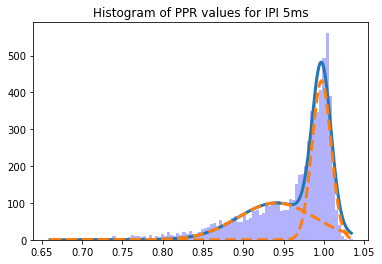

            params     sigma
mu1       0.429871  0.008039
sigma1    0.046117  0.008179
A1       43.577378  6.271466
mu2       0.734182  0.002194
sigma2    0.120310  0.002391
A2      257.895288  3.947957


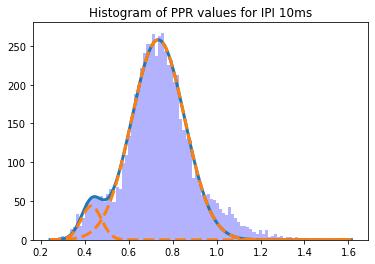

            params     sigma
mu1       0.582816  0.002129
sigma1    0.058348  0.002852
A1      164.036032  7.943360
mu2       0.684205  0.005832
sigma2    0.150164  0.003168
A2      165.963890  6.456779


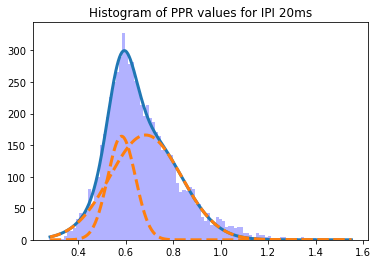

            params      sigma
mu1       0.558308   0.003508
sigma1    0.073383   0.005670
A1      209.616368  37.286708
mu2       0.711561   0.048947
sigma2    0.128303   0.023439
A2       88.580252  16.135313


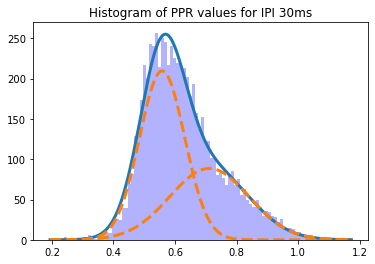

            params     sigma
mu1       0.611710  0.002725
sigma1    0.156816  0.002920
A1      181.678869  4.035974
mu2       0.568829  0.003139
sigma2    0.027306  0.003747
A2       61.827208  6.754933


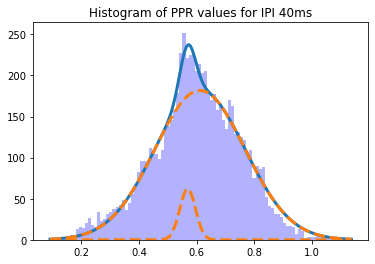

            params     sigma
mu1       0.634725  0.002564
sigma1    0.147524  0.002344
A1      182.506921  3.545547
mu2       0.568922  0.001769
sigma2    0.029115  0.002105
A2      101.183391  5.820840


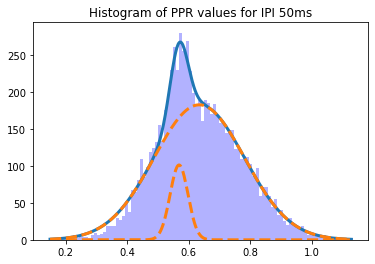

            params      sigma
mu1       0.608104   0.002820
sigma1    0.038008   0.003684
A1      162.688781  12.794514
mu2       0.633464   0.005649
sigma2    0.170286   0.007011
A2      177.548056   9.894188


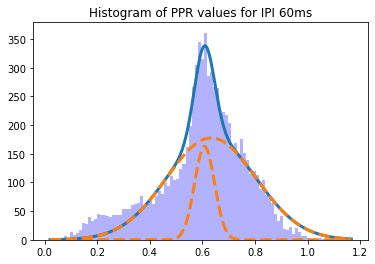

            params     sigma
mu1       0.581964  0.002853
sigma1    0.074237  0.002322
A1      276.488529  5.601007
mu2       0.809238  0.004500
sigma2    0.094382  0.004007
A2      209.255695  4.146347


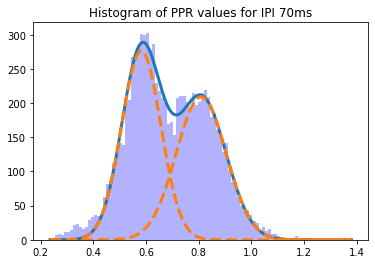

            params     sigma
mu1       0.472419  0.011542
sigma1    0.101392  0.009293
A1       88.194694  4.349689
mu2       0.748104  0.005012
sigma2    0.107117  0.004055
A2      212.806503  3.995133


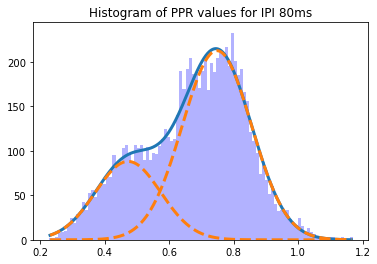

            params      sigma
mu1       0.646049   0.008505
sigma1    0.077266   0.004439
A1      194.365766  20.727114
mu2       0.821076   0.014083
sigma2    0.098409   0.007881
A2      179.545366  11.137085


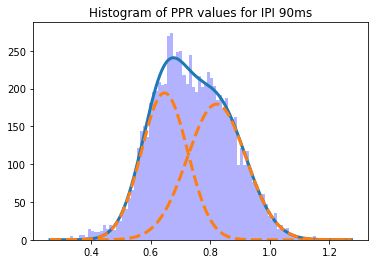

            params      sigma
mu1       0.685336   0.003767
sigma1   -0.050180   0.003120
A1      197.133834  12.955891
mu2       0.844650   0.005192
sigma2    0.083513   0.004331
A2      253.652408   5.463673


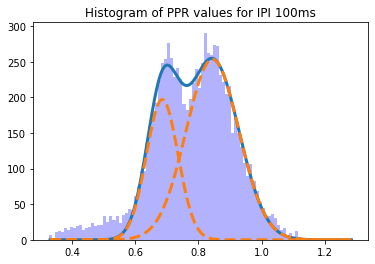

            params      sigma
mu1       0.680234   0.022188
sigma1   -0.090470   0.009756
A1      137.439289  25.626486
mu2       0.854858   0.013811
sigma2   -0.093818   0.006245
A2      237.103651  23.274096


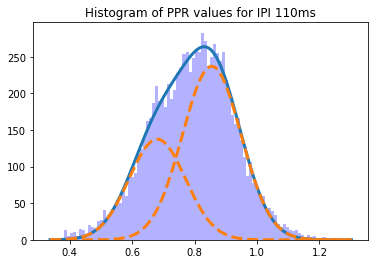

            params     sigma
mu1       0.797326  0.001273
sigma1    0.044649  0.001723
A1      194.124505  7.976615
mu2       0.857773  0.003035
sigma2    0.110214  0.001863
A2      202.123990  7.360191


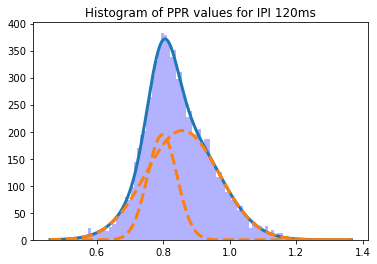

            params     sigma
mu1       0.578878  0.028743
sigma1    0.069334  0.026184
A1       24.667386  6.506875
mu2       0.829530  0.003042
sigma2    0.107726  0.003053
A2      312.927936  4.626998


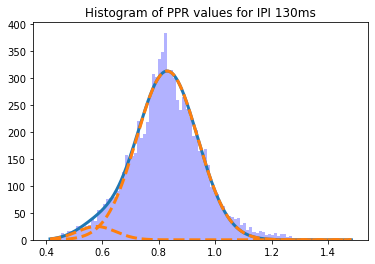

            params      sigma
mu1       0.874364   0.002461
sigma1    0.110494   0.002569
A1      218.617033  10.380937
mu2       0.840876   0.001563
sigma2    0.041436   0.002328
A2      167.873010  10.340646


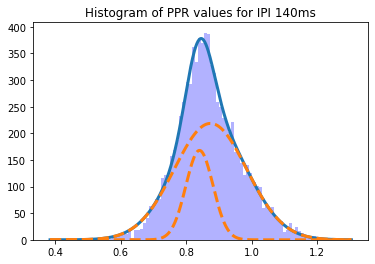

            params     sigma
mu1       0.799165  0.010374
sigma1    0.167671  0.018524
A1       43.582607  9.602671
mu2       0.795342  0.001840
sigma2    0.061964  0.003246
A2      148.915585  9.289586


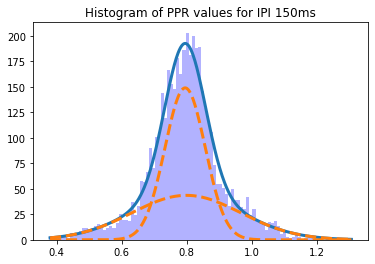

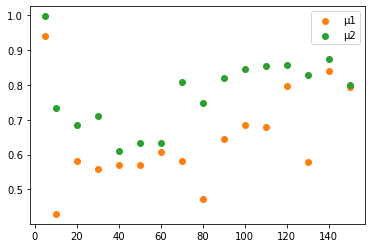

In [32]:
expected = {
    5: (0.7, .02, 25, 0.8, .02, 15),
    10: (0.4, .02, 45, 0.8, 0.1, 150),
    20: (0.6, .02, 25, 0.85, .02, 15),
    30: (0.6, .02, 25, 0.85, .02, 15),
    40: (0.45, .02, 25, 0.85, .02, 15),
    50: (0.4, .02, 25, 0.85, .02, 15),
    60: (0.6, .02, 25, 0.85, .02, 15),
    70: (0.6, .02, 25, 0.85, .02, 15),
    80: (0.5, .02, 25, 0.85, .02, 15),
}
# plot histogram of PPR values
# now for each IPI
ipis = list(ppr_hist.keys())
ipis.sort()
ppr_hist_pngs = []
ppr_depressions = {}
for ipi in ipis:

    y,x,_=plt.hist(ppr_hist[ipi], bins=100, color='b', alpha=0.3)
    plt.title("Histogram of PPR values for IPI " + str(ipi) + "ms")

    #data generation
    np.random.seed(123)
    x=(x[1:]+x[:-1])/2 # for len(x)==len(y)

    #x, y inputs can be lists or 1D numpy arrays

    def gauss(x, mu, sigma, A):
        return A*np.exp(-(x-mu)**2/2/sigma**2)

    def bimodal(x, mu1, sigma1, A1, mu2, sigma2, A2):
        return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)
    
    expe = (0.5, .02, 25, 0.85, .02, 15)
    if ipi in expected:
        expe = expected[ipi]

    params, cov = curve_fit(bimodal, x, y, expe)
    sigma=np.sqrt(np.diag(cov))
    x_fit = np.linspace(x.min(), x.max(), 500)
    #plot combined...
    plt.plot(x_fit, bimodal(x_fit, *params), color='tab:blue', lw=3)
    #...and individual Gauss curves
    plt.plot(x_fit, gauss(x_fit, *params[:3]), 
            color='tab:orange', lw=3, ls="--", label='mean PPR: 0.74 ± 0.01' )
    plt.plot(x_fit, gauss(x_fit, *params[3:]), 
            color='tab:orange', lw=3, ls="--", label='mean PPR: 0.82 ± 0.07')
    #and the original data points if no histogram has been created before
    #plt.scatter(x, y, marker="X", color="black", label="original data")
    #plt.legend(loc = 'upper left')
    #plt.ylim(0, 17)
    #plt.xlim(0.2, 1.2)
    print(pd.DataFrame(data={'params': params, 'sigma': sigma}, index=bimodal.__code__.co_varnames[1:]))
    # save mu1 and mu2
    ppr_depressions[ipi] = [params[0], params[3]]
    ppr_depressions[ipi].sort()


    plt.savefig(subdir + "/PPR_hist_" + str(ipi) + "ms.png", dpi=300, bbox_inches='tight')
    ppr_hist_pngs.append(subdir + "/PPR_hist_" + str(ipi) + "ms.png")
    plt.show() 



In [ ]:
# plot PPR mu1 and mu2 versus IPI
ppr_df = pd.DataFrame(ppr_depressions).T
ppr_df.columns = ['mu1', 'mu2']
ppr_df['ipi'] = ppr_df.index
plt.scatter(ppr_df['ipi'], ppr_df['mu1'], c='tab:orange', label='μ1')
plt.scatter(ppr_df['ipi'], ppr_df['mu2'], c='tab:green', label='μ2')
plt.xlabel("IPI (ms)")
plt.ylabel("PPR distribution mean")
plt.legend()

In [27]:
# make movie out of ppr_hist_pngs 
import imageio
movie = [imageio.imread(filename) for filename in ppr_hist_pngs]
imageio.mimsave(subdir + "/PPR_hist_movie.gif", movie, fps=2)

In [23]:
subdir + "/PPR_hist_movie.gif"

'P:/John/analyzed_archived/scnn1a-tg3-cre/PPR_checkpoints/scnn1a-ppr/12-19-23\\selected_zda/PPR_hist_movie.gif'

In [ ]:
# plot histogram of PPR values
# now for each IPI
y,x,_=plt.hist(ppr_hist, bins=100, color='b', alpha=0.3)
plt.title("Histogram of PPR values")


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

#data generation
np.random.seed(123)
x=(x[1:]+x[:-1])/2 # for len(x)==len(y)

#x, y inputs can be lists or 1D numpy arrays

def gauss(x, mu, sigma, A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x, mu1, sigma1, A1, mu2, sigma2, A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

expected = (0.7, .02, 25, 0.8, .02, 15)
params, cov = curve_fit(bimodal, x, y, expected)
sigma=np.sqrt(np.diag(cov))
x_fit = np.linspace(x.min(), x.max(), 500)
#plot combined...
plt.plot(x_fit, bimodal(x_fit, *params), color='tab:blue', lw=3)
#...and individual Gauss curves
'''plt.plot(x_fit, gauss(x_fit, *params[:3]), 
         color='tab:orange', lw=3, ls="--", label='mean PPR: 0.74 ± 0.01' )
plt.plot(x_fit, gauss(x_fit, *params[3:]), 
         color='tab:green', lw=3, ls=":", label='mean PPR: 0.82 ± 0.07')'''
#and the original data points if no histogram has been created before
#plt.scatter(x, y, marker="X", color="black", label="original data")
#plt.legend(loc = 'upper left')
#plt.ylim(0, 17)
#plt.xlim(0.2, 1.2)
print(pd.DataFrame(data={'params': params, 'sigma': sigma}, index=bimodal.__code__.co_varnames[1:]))
plt.show() 